# Lab 3: Extending Logistic Regression


***Christopher Cook, Bonita Davis, Anekah Kelley, Davis Lynn***
## 1. Preparation and Overview
### **1.1 Business Understanding**

This is a dataset of 15,149 songs from 3,083 artists over the course of over a century (1899-2024).  It is sorted by 18 different features:
*    Track (string)
*    Artist (string)
*    Year (int)
*    Duration (int, in ms)
*    Time Signature (int, numerator of time signature; i.e. 4 means 4/4)
*    Danceability (float, 0-10)
*    Energy (float 0-1)
*    Key (int, 0-11; 0 = C, etc.)
*    Loudness (float, loudness in db -47.4=0.92)
*    Mode (int, major/minor modality; 0/1)
*    Speechiness (float, 0-1)
*    Acousticness (float, 0-1)
*    Instrumentalness (float 0-1)
*    Liveness (float, 0-1)
*    Valence (float, 0-1)
*    Tempo (tempo, BPM from 0-220)
*    Popularity (int, 0-100)
*    Genre (string)

This data was collected directly from the Spotify API, allowing for additional attributes such as Loudness, Speechiness, etc. The dataset is free to download on Kaggle through the link below.

Data Source: https://www.kaggle.com/datasets/thebumpkin/10400-classic-hits-10-genres-1923-to-2023/data

The task of this dataset is to serve as a touchpoint for individuals in the music industry to explore trends, compare genres, analyze sonic qualities, and see how classic hits across time periods and genres compare to once another (Kaggle).  The sheer size of the dataset, along with the amount of information provided about each song, makes this an excellent resource to understand musical trends.  It can also be used to see how an individual artist or genre has performed over time, providing insights into how future songs/albums might perform.

This is the primary business-case of this dataset and our classifier -- attempting to predict attributes about songs.  This information can be used by companies like Spotify and Apple Music to predict the likelihood that a user will like a song based on the attributes of the songs they have been previously shown to like (if they typically like pop music with a loudness of 97, that information can be used to predict new songs that they may also like).  These businesses care more about the relationships between all of the attributes, as it is the combination of these attributes that creates a listening style.  This information could also be used by a music producer or musician to determine what attributes about songs in different genres/time periods tend to make them popular in order to see how to best leverage the artist's skills to create a hit song.  These businesses care more about the interplay between the attributes that they deem to be relevant based on the artist and popularity, as that gives the best blueprint for success.

This model would likely be deployed, although it may differ depending on the user.  Users like Spotify, Apple Music, YouTube Music, and other such companies would use this data constantly, making it a deployed model.  In contrast, while some music producers may consistently run new models, it is possible that it could be semi-offline and just generated once for the relevant artists.  This data was likely collected with these intentions in mind, as classifiers could be trained and sold to such businesses for a sizeable amount of money.

The use of such a classifier by companies like Spotify and Apple Music is supported by the fact that Spotify currently uses a similar classifier to create their "Made For You" playlist provided to users (https://www.music-tomorrow.com/blog/how-spotify-recommendation-system-works-a-complete-guide-2022).  They use very similar attributes (which is the case because our dataset directly incorporates Spotify information) to predict the likelihood that a user will enjoy a song based on their listening history.  Spotify's algorithm is many times more complex than anything we would be capable of creating at this point in time, so holding ourselves to that standard would be simply foolish.  Additionally, Spotify does not publish an "accuracy" rate for predicting songs.  Further complicating the problem, an NIH study showed that roughly 15% of people skip songs that they haven't listened to, before even listening to it, and that others skipped the songs shortly after starting them if they didn't quickly enjoy the song (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7004375/).  While this is a relatively small percentage, it shows the importance of a very accurate classifier.  Ideally, a classifier with a roughly 90% accuracy is likely possible with advanced algorithms, predicts songs with an acceptable margin of error, and will result in benefits for companies.

For music producers and artists interested in predicting the success of their songs, a much lower bar of accuracy is acceptable.  Similar classifier algorithms boast an accuracy of anywhere between 55-77% (https://cs229.stanford.edu/proj2015/140_report.pdf, https://towardsdatascience.com/song-popularity-predictor-1ef69735e380, https://www.nature.com/articles/s41598-022-25430-9).  In truth, anything able to predict with an accuracy greater than 50% would be considered successful to some degree, as popularity is highly subjective, changes dramatically over time, and is often a product of purely qualitative features that are difficult to connect to quantitative information, despite best efforts.  Aiming for an accuracy of roughly 65% would put our model squarely in the middle of currently available algorithms, making it both realistic and acceptable in the industry.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("ClassicHit.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track             15149 non-null  object 
 1   Artist            15149 non-null  object 
 2   Year              15149 non-null  int64  
 3   Duration          15149 non-null  int64  
 4   Time_Signature    15149 non-null  int64  
 5   Danceability      15149 non-null  float64
 6   Energy            15149 non-null  float64
 7   Key               15149 non-null  int64  
 8   Loudness          15149 non-null  float64
 9   Mode              15149 non-null  int64  
 10  Speechiness       15149 non-null  float64
 11  Acousticness      15149 non-null  float64
 12  Instrumentalness  15149 non-null  float64
 13  Liveness          15149 non-null  float64
 14  Valence           15149 non-null  float64
 15  Tempo             15149 non-null  float64
 16  Popularity        15149 non-null  int64 

For each column, there are 15,150 non-null rows, so there is no obviously missing data. We will want to check further to see if any of the entries are duplicates or contain data that are outside of the expected range.

#### Removing Duplicates

In [2]:
df[df.duplicated(subset=['Track', 'Artist'], keep=False)]

,Track,Artist,Year,Duration,Time_Signature,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Popularity,Genre
18,Man in the Box,Alice In Chains,1990,285200,4,0.355,0.79100,8,-7.565,1,0.0453,0.00045,0.000000,0.0969,0.758,106.392,77,Alt. Rock
19,Angry Chair (2022 Remaster),Alice In Chains,1992,287800,4,0.329,0.94300,8,-5.742,1,0.0913,0.04060,0.000000,0.0548,0.157,107.422,53,Alt. Rock
20,Down In A Hole (2022 Remaster),Alice In Chains,1992,338226,4,0.356,0.81800,6,-5.343,1,0.0335,0.01220,0.000118,0.1230,0.389,97.528,66,Alt. Rock
21,Rooster (2022 Remaster),Alice In Chains,1992,374333,3,0.263,0.56200,3,-7.858,1,0.0273,0.02890,0.001180,0.1200,0.213,146.080,72,Alt. Rock
22,Them Bones (2022 Remaster),Alice In Chains,1992,149466,1,0.160,0.95400,9,-5.179,1,0.0685,0.02300,0.000004,0.3720,0.336,165.223,70,Alt. Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15114,Dark End of the Street,Ry Cooder,1976,207040,4,0.499,0.09280,7,-16.868,1,0.0405,0.67100,0.557000,0.1850,0.192,119.739,28,World
15116,He'll Have to Go,Ry Cooder,1977,309240,4,0.413,0.29100,5,-14.624,1,0.0339,0.30000,0.000000,0.2380,0.777,181.975,33,World
15118,"Paris,Texas",Ry Cooder,1985,174760,5,0.359,0.00681,7,-20.957,1,0.0602,0.94500,0.158000,0.0581,0.205,128.713,46,World
15133,Tom Dooley,The Kingston Trio,1958,183973,4,0.649,0.14400,4,-13.986,1,0.0418,0.80600,0.000005,0.1050,0.458,125.740,41,World


Removing All duplicates based on combination of Song and Artist name, in total 558 values

In [3]:
# remove the entries with the out of range years
df = df[(df['Year'] >= 1923) & (df['Year'] <= 2023)]
del df['Time_Signature']
df = df[(df['Tempo'] > 0)]


To further clean the data, we are removing songs that are outside of the 100 years, removing time signatures as they are not significantly diverse, and any songs with a bpm of 0.

In [4]:
import pandas as pd

# Assuming df is your DataFrame containing the dataset
# df = pd.read_csv('your_dataset.csv')

# Calculate summary statistics (for numeric columns only)
summary_stats = df.describe().T

# Create a new DataFrame for the data summary
data_des = pd.DataFrame()

# Add attributes and descriptions
data_des['Attributes'] = df.columns
data_des['Description'] = ['Name of song', 'Name of singer', 'Year released', 'Length of song in milliseconds',
        'Suitability of dancing (0-1)', 'Intensity of the song (0-1)', 'Key of the track (0-11)', 'Loudness of track in dB', 'Modality (major or minor)',
        'Measures the presence of spoken words (0-1)', 'Measure of how acoustic the track is (0-1)', 'Measure of likelihood that track is instrumental (0-1)',
        'Measure of the presence of a live audience (0-1)', 'Measure of musical positiveness (0-1)', 'Speed of the track (BPM)', 'Track popularity (0-100)',
        'Musical genre of the song']

# Initialize mean, std deviation, and range columns with 'N/A'
data_des['Mean'] = 'N/A'
data_des['Std Deviation'] = 'N/A'
data_des['Range'] = 'N/A'

# Update mean, std deviation, and range for numeric columns
for col in summary_stats.index:
    data_des.loc[data_des['Attributes'] == col, 'Mean'] = summary_stats.loc[col, 'mean']
    data_des.loc[data_des['Attributes'] == col, 'Median'] = summary_stats.loc[col, '50%']
    data_des.loc[data_des['Attributes'] == col, 'Std Deviation'] = summary_stats.loc[col, 'std']
    data_des.loc[data_des['Attributes'] == col, 'Range'] = f"{summary_stats.loc[col, 'min']}-{summary_stats.loc[col, 'max']}"
    data_des.loc[data_des['Attributes'] == col, 'IQR'] = f"{summary_stats.loc[col, '25%']}-{summary_stats.loc[col, '75%']}"

# Display the data summary
data_des


/tmp/ipykernel_483/3125383170.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1971.0-1998.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_des.loc[data_des['Attributes'] == col, 'IQR'] = f"{summary_stats.loc[col, '25%']}-{summary_stats.loc[col, '75%']}"


,Attributes,Description,Mean,Std Deviation,Range,Median,IQR
0,Track,Name of song,N/A,N/A,N/A,NaN,NaN
1,Artist,Name of singer,N/A,N/A,N/A,NaN,NaN
2,Year,Year released,1984.738202,19.368198,1923.0-2023.0,1983.000000,1971.0-1998.0
3,Duration,Length of song in milliseconds,241292.887178,105809.168331,23000.0-3060650.0,222833.000000,180323.25-275219.5
4,Danceability,Suitability of dancing (0-1),0.574894,0.166073,0.0684-0.988,0.582000,0.461-0.696
5,Energy,Intensity of the song (0-1),0.617866,0.239281,9.77e-05-0.999,0.644000,0.443-0.819
6,Key,Key of the track (0-11),5.259484,3.569293,0.0-11.0,5.000000,2.0-8.0
7,Loudness,Loudness of track in dB,-9.146272,4.263725,-42.95-0.919,-8.476500,-11.73075--5.9575
8,Mode,Modality (major or minor),0.696497,0.459786,0.0-1.0,1.000000,0.0-1.0
9,Speechiness,Measures the presence of spoken words (0-1),0.075816,0.077737,0.0223-0.95,0.046400,0.0343-0.0784




#### Grouping Classes

We are reassigning the genre class into broader groups to reduce calculation time and improve results.

In [5]:
print(df['Genre'].unique())

['Alt. Rock' 'Blues' 'Country' 'Disco' 'EDM' 'Folk' 'Funk' 'Gospel' 'Jazz'
 'Metal' 'Pop' 'Punk' 'R&B' 'Rap' 'Reggae' 'Rock' 'SKA' 'Today' 'World']


Based on the total 19 genres above, we decided to split the groups into as follows:
* Rock: Alt. Rock, Metal, Punk, Rock 
* Pop: Pop, Today, EDM, Disco
* Hip-Hop: Rap, R&B
* Country: Blues, Folk, Country
* Soul: Jazz, Funk, Gospel
* International: SKA, Reggae, World


In [6]:
map_genre = {
    'Alt. Rock': 'Rock',
    'Metal': 'Rock',
    'Punk': 'Rock',
    'Rock': 'Rock',
    'Pop': 'Pop',
    'EDM': 'Pop',
    'Disco': 'Pop',
    'Today': 'Pop',
    'Rap': 'Hip-Hop',
    'R&B': 'Hip-Hop',
    'Blues': 'Country',
    'Folk': 'Country',
    'Country': 'Country',
    'Jazz': 'Soul',
    'Funk': 'Soul',
    'Gospel': 'Soul',
    'Reggae': 'International',
    'World': 'International',
    'SKA' : 'International'
}

# Replace the genres with the new categories
df['Genre'] = df['Genre'].map(map_genre)

# check there are only 6 genres now
print(df['Genre'].unique())


['Rock' 'Country' 'Pop' 'Soul' 'Hip-Hop' 'International']


#### One Hot Encoding of Categories
We are one hot encoding applicable categorical variables, there are 4: Track/Artist, Mode, Genre, and Key. However, only one of these can actually be One Hot Encoded for the following reasons
* Track and Artist: We remove these columns due to the sheer variation represented within the data.
* Mode: mode can only be 0 or 1, thus not requiring one hot encoding
* Genre: This is our target variable, more mapping will come here later on.
* Key: therefore, we will only one hot encode Key.

In [7]:
# deleting categorical data of Artist and Track
del df['Track']
del df['Artist']
#grabbing existing category that doesn't need One Hot
categ_features = ['Key']
#Generating One Hot for Key
one_hot = pd.concat([pd.get_dummies(df[col],prefix=col).astype(int) for col in categ_features], axis=1)

one_hot.head()

,Key_0,Key_1,Key_2,Key_3,Key_4,Key_5,Key_6,Key_7,Key_8,Key_9,Key_10,Key_11
0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0


In [8]:
# removing existing key column
del df['Key']

#appending to the existing DF
df = pd.concat([df, one_hot], axis=1)

# Assigning Each Key to the corresponding note
key_mapping = {'Key_0': 'Key_C', 'Key_1': 'Key_C#', 'Key_2': 'Key_D','Key_3': 'Key_D#', 'Key_4': 'Key_E', 'Key_5': 'Key_F', 'Key_6': 'Key_F#','Key_7': 'Key_G', 'Key_8': 'Key_G#','Key_9': 'Key_A','Key_10': 'Key_A#','Key_11': 'Key_B',}
df.rename(columns=key_mapping, inplace=True)

df.head()

,Year,Duration,Danceability,Energy,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,...,Key_D,Key_D#,Key_E,Key_F,Key_F#,Key_G,Key_G#,Key_A,Key_A#,Key_B
0,1987,206413,0.616,0.511,-15.894,1,0.0279,0.03840,0.000000,0.1500,...,0,0,0,0,1,0,0,0,0,0
1,1987,236653,0.770,0.459,-17.453,1,0.0416,0.11200,0.003430,0.1450,...,0,0,0,0,0,0,0,0,0,0
2,1987,291173,0.593,0.816,-7.293,1,0.0410,0.00449,0.000032,0.0896,...,0,0,0,0,0,0,0,1,0,0
3,1989,193560,0.861,0.385,-10.057,1,0.0341,0.15400,0.000000,0.1230,...,1,0,0,0,0,0,0,0,0,0
4,1992,185960,0.622,0.876,-6.310,1,0.0305,0.01930,0.006840,0.0987,...,0,0,0,0,0,0,0,0,1,0


#### Normalizing Data

We must normalize our numeric data, which consists of 12 categories listed below.

In [9]:
numerics = ['Year', 'Duration', 'Danceability', 'Energy', 'Loudness', 'Speechiness', 
                'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Popularity']

# subtracts off the mean and divides by the standard deviation
df[numerics] = (df[numerics] - df[numerics].mean()) / df[numerics].std()

df.head()

,Year,Duration,Danceability,Energy,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,...,Key_D,Key_D#,Key_E,Key_F,Key_F#,Key_G,Key_G#,Key_A,Key_A#,Key_B
0,0.116779,-0.329649,0.247516,-0.446612,-1.582590,1,-0.616385,-0.831196,-0.396752,-0.285768,...,0,0,0,0,1,0,0,0,0,0
1,0.116779,-0.043851,1.174821,-0.663930,-1.948233,1,-0.440150,-0.599352,-0.381725,-0.314294,...,0,0,0,0,0,0,0,0,0,0
2,0.116779,0.471416,0.109023,0.828041,0.434660,1,-0.447868,-0.938014,-0.396613,-0.630360,...,0,0,0,0,0,0,0,1,0,0
3,0.220041,-0.451122,1.722774,-0.973190,-0.213599,1,-0.536629,-0.467051,-0.396752,-0.439808,...,1,0,0,0,0,0,0,0,0,0
4,0.374934,-0.522950,0.283645,1.078793,0.665210,1,-0.582939,-0.891362,-0.366786,-0.578443,...,0,0,0,0,0,0,0,0,1,0


#### Genres to Integers

In order to run the classifier, we must convert the genres to various integers

In [10]:
genre_numbers = {'Rock': 0,'Pop': 1,'Hip-Hop': 2,'Country': 3,'Soul': 4,'International': 5}

# Replace the genres with the new categories
df['GenreVal'] = df['Genre'].map(genre_numbers)
del df['Genre']
col_to_move3 = df.pop('GenreVal')
df.insert(0, 'GenreVal', col_to_move3) 

df.head()

,GenreVal,Year,Duration,Danceability,Energy,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,...,Key_D,Key_D#,Key_E,Key_F,Key_F#,Key_G,Key_G#,Key_A,Key_A#,Key_B
0,0,0.116779,-0.329649,0.247516,-0.446612,-1.582590,1,-0.616385,-0.831196,-0.396752,...,0,0,0,0,1,0,0,0,0,0
1,0,0.116779,-0.043851,1.174821,-0.663930,-1.948233,1,-0.440150,-0.599352,-0.381725,...,0,0,0,0,0,0,0,0,0,0
2,0,0.116779,0.471416,0.109023,0.828041,0.434660,1,-0.447868,-0.938014,-0.396613,...,0,0,0,0,0,0,0,1,0,0
3,0,0.220041,-0.451122,1.722774,-0.973190,-0.213599,1,-0.536629,-0.467051,-0.396752,...,1,0,0,0,0,0,0,0,0,0
4,0,0.374934,-0.522950,0.283645,1.078793,0.665210,1,-0.582939,-0.891362,-0.366786,...,0,0,0,0,0,0,0,0,1,0


In [11]:
import pandas as pd

# Assuming df is your DataFrame containing the dataset
# df = pd.read_csv('your_dataset.csv')

# Calculate summary statistics (for numeric columns only)
summary_stats = df.describe().T

# Create a new DataFrame for the data summary
data_des = pd.DataFrame()

# Add attributes and descriptions
data_des['Attributes'] = df.columns
data_des['Description'] = ['Genre Value', 'Year Released', 'Length',
        'Suitability of dancing (0-1)', 'Intensity of the song (0-1)', 'Loudness of track in dB', 'Modality (major or minor)',
        'Measures the presence of spoken words (0-1)', 'Measure of how acoustic the track is (0-1)', 'Measure of likelihood that track is instrumental (0-1)',
        'Measure of the presence of a live audience (0-1)', 'Measure of musical positiveness (0-1)', 'Speed of the track (BPM)', 'Track popularity (0-100)',
        'One Hot for C Key', 'One Hot for C# Key', 'One Hot for D Key', 'One Hot for D# Key', 'One Hot for E Key', 'One Hot for F Key', 'One Hot for F# Key', 'One Hot for G Key', 'One Hot for G# Key', 'One Hot for A Key','One Hot for A# Key', 'One Hot for B Key']


# Initialize mean, std deviation, and range columns with 'N/A'
data_des['Mean'] = 'N/A'
data_des['Std Deviation'] = 'N/A'
data_des['Range'] = 'N/A'

# Update mean, std deviation, and range for numeric columns
for col in summary_stats.index:
    data_des.loc[data_des['Attributes'] == col, 'Mean'] = summary_stats.loc[col, 'mean']
    data_des.loc[data_des['Attributes'] == col, 'Median'] = summary_stats.loc[col, '50%']
    data_des.loc[data_des['Attributes'] == col, 'Std Deviation'] = summary_stats.loc[col, 'std']
    data_des.loc[data_des['Attributes'] == col, 'Range'] = f"{summary_stats.loc[col, 'min']}-{summary_stats.loc[col, 'max']}"
    data_des.loc[data_des['Attributes'] == col, 'IQR'] = f"{summary_stats.loc[col, '25%']}-{summary_stats.loc[col, '75%']}"

# Display the data summary
data_des


/tmp/ipykernel_483/2698771565.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.0-3.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_des.loc[data_des['Attributes'] == col, 'IQR'] = f"{summary_stats.loc[col, '25%']}-{summary_stats.loc[col, '75%']}"


,Attributes,Description,Mean,Std Deviation,Range,Median,IQR
0,GenreVal,Genre Value,1.757568,1.542933,0.0-5.0,1.000000,1.0-3.0
1,Year,Year Released,-0.0,1.0,-3.187606873090627-1.975495966101055,-0.089745,-0.7093175102786197-0.6847202563031344
2,Duration,Length,-0.0,1.0,-2.063081022379795-26.645678794094586,-0.174464,-0.5762226292808028-0.32063963224837494
3,Danceability,Suitability of dancing (0-1),-0.0,1.0,-3.049834559299175-2.4874988502334086,0.042787,-0.6858098783699751-0.7292329133222355
4,Energy,Intensity of the song (0-1),-0.0,1.0,-2.581769358168641-1.5928330200200649,0.109221,-0.730796550432341-0.8405788425354728
5,Loudness,Loudness of track in dB,0.0,1.0,-7.928215729883051-2.360676005653496,0.157086,-0.606154973662272-0.7478841932251967
6,Mode,Modality (major or minor),0.696497,0.459786,0.0-1.0,1.000000,0.0-1.0
7,Speechiness,Measures the presence of spoken words (0-1),0.0,1.0,-0.688422953554811-11.245399295662812,-0.378403,-0.5340563835530739-0.03324076120330985
8,Acousticness,Measure of how acoustic the track is (0-1),0.0,1.0,-0.952154355995288-2.185287223043607,-0.429250,-0.8756114147583328-0.7992674632073885
9,Instrumentalness,Measure of likelihood that track is instrument...,0.0,1.0,-0.3967516096530384-3.927162770774503,-0.396391,-0.3967516096530384--0.3433050489223231


This is our data after various actions above was acted upon it, as expected the Mean is 0 and the Std Deviation for each of our numeric values is 0 and 1 respectively due to normalization.
### Training and Testing Split

In [12]:
from sklearn.model_selection import train_test_split

# splitting into X and Y
df = np.array(df)
X = df[:, 1:]
y = df[:, 0]

# seperate Data
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size=0.2)

# check dimensions
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12104, 25)
(12104,)
(3026, 25)
(3026,)


Our team elected to use the standard 80% training, 20% testing split for our data.  This split is appropriate for several reasons.
1.   Our data contains information about over 15,000 songs, making the 80% of training data represent over 12,000 songs.  This is a more than adequate amount of data to train our classifier and provide it with many different combinations of attributes.
2.   The size of our dataset also means that the 20% testing data represents over 3,000 songs, making it a large enough chunk of data that we can provide reasonable accuracies that reflect the actual accuracy of the classifier.
3.   This split is the the industry standard for datasets, as it has been proven time and time again that a split of roughly 70-80% training and 20-30% testing provides the best resuls (https://scholarworks.utep.edu/cs_techrep/1209/)


## 2. Modeling

###  Custom Linear Regression Classifier

The following code contains the classifier in line with professor's notes

In [18]:
from scipy.special import expit
from scipy.optimize import minimize_scalar
from numpy import ma
from numpy.linalg import pinv

class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001, regularization="none"):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.regularization = regularization

    def __str__(self):
        if hasattr(self, 'w_'):
            return 'Binary Logistic Regression Object with coefficients:\n' + str(self.w_)
        else:
            return 'Untrained Binary Logistic Regression Object'

    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0], 1)), X))

    @staticmethod
    def _sigmoid(theta):
        return expit(theta)

    def _get_gradient(self, X, y):
        ydiff = y - self.predict_proba(X, add_bias=False).ravel()
        gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)
        gradient = gradient.reshape(self.w_.shape)
        if self.regularization == 'L1':
            gradient[1:] += np.sign(self.w_[1:]) * self.C
        elif self.regularization == 'L1_L2':
            gradient[1:] += -2 * self.w_[1:] * self.C + np.sign(self.w_[1:]) * self.C
        elif self.regularization == 'L2':
            gradient[1:] += -2 * self.w_[1:] * self.C
        return gradient

    def predict_proba(self, X, add_bias=True):
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_)

    def predict(self, X):
        return self.predict_proba(X) > 0.5

    def fit(self, X, y):
        Xb = self._add_bias(X)
        num_samples, num_features = Xb.shape
        self.w_ = np.zeros((num_features, 1))
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb, y)
            self.w_ += gradient * self.eta

class LineSearchLogisticRegression(BinaryLogisticRegression):
    def __init__(self, line_iters=0.0, **kwds):
        self.line_iters = line_iters
        super().__init__(**kwds)

    @staticmethod
    def objective_function(eta, X, y, w, grad, C):
        wnew = w - grad * eta
        g = expit(X @ wnew)
        return -np.sum(ma.log(g[y == 1])) - ma.sum(ma.log(1 - g[y == 0])) + C * sum(wnew[1:] ** 2)

    def fit(self, X, y):
        Xb = self._add_bias(X)
        num_samples, num_features = Xb.shape
        self.w_ = np.zeros((num_features, 1))
        for _ in range(self.iters):
            gradient = -self._get_gradient(Xb, y)
            opts = {'maxiter': self.line_iters}
            res = minimize_scalar(self.objective_function, bounds=(0, self.eta * 10), args=(Xb, y, self.w_, gradient, self.C), method='bounded', options=opts)
            eta = res.x
            self.w_ -= gradient * eta

class StochasticLogisticRegression(LineSearchLogisticRegression):
    def _get_gradient(self, X, y):
        mini_batch_size = 16
        idxs = np.random.choice(len(y), mini_batch_size)
        ydiff = y[idxs] - self.predict_proba(X[idxs], add_bias=False).ravel()
        gradient = np.mean(X[idxs] * ydiff[:, np.newaxis], axis=0)
        gradient = gradient.reshape(self.w_.shape)
        if self.regularization == 'L1':
            gradient[1:] += np.sign(self.w_[1:]) * self.C
        elif self.regularization == 'L1_L2':
            gradient[1:] += -2 * self.w_[1:] * self.C + np.sign(self.w_[1:]) * self.C
        elif self.regularization == 'L2':
            gradient[1:] += -2 * self.w_[1:] * self.C
        return gradient

from scipy.optimize import fmin_bfgs

class HessianBinaryLogisticRegression(StochasticLogisticRegression):
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel()
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C

        ydiff = y-g
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(self.w_.shape)
        if self.regularization == 'L1':
            gradient[1:] += np.sign(self.w_[1:]) * self.C
        elif self.regularization == 'L1_L2':
            gradient[1:] += -2*self.w_[1:] * self.C + np.sign(self.w_[1:]) * self.C
        elif self.regularization == 'L2':
            gradient[1:] += -2*self.w_[1:] * self.C
        
        return pinv(hessian) @ gradient
class BFGSBinaryLogisticRegression(HessianBinaryLogisticRegression):
    @staticmethod
    def objective_function(w, X, y, C, regularization):
        g = expit(X @ w)
        return -ma.sum(ma.log(g[y == 1])) - ma.sum(ma.log(1 - g[y == 0])) + C * sum(w ** 2)

    @staticmethod
    def objective_gradient(w, X, y, C, regularization):
        g = expit(X @ w)
        ydiff = y - g
        gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        if regularization == 'L1':
            gradient[1:] += np.sign(w[1:]) * C
        elif regularization == 'L1_L2':
            gradient[1:] += -2 * w[1:] * C + np.sign(w[1:]) * C
        elif regularization == 'L2':
            gradient[1:] += -2 * w[1:] * C
        return -gradient

    def fit(self, X, y):
        Xb = self._add_bias(X)
        num_samples, num_features = Xb.shape
        self.w_ = fmin_bfgs(self.objective_function, np.zeros((num_features, 1)), fprime=self.objective_gradient, args=(Xb, y, self.C, self.regularization), gtol=1e-03, maxiter=self.iters, disp=False)
        self.w_ = self.w_.reshape((num_features, 1))

class MultiClassLogisticRegression(BFGSBinaryLogisticRegression):
    def __init__(self, eta, iterations=20, C=0.0001, solver=BFGSBinaryLogisticRegression):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solver = solver
        self.classifiers_ = []

    def __str__(self):
        if hasattr(self, 'w_'):
            return 'MultiClass Logistic Regression Object with coefficients:\n' + str(self.w_)
        else:
            return 'Untrained MultiClass Logistic Regression Object'

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y))
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i, yval in enumerate(self.unique_):
            y_binary = np.array(y == yval).astype(int)
            hblr = self.solver(eta=self.eta, iterations=self.iters, C=self.C)
            hblr.fit(X, y_binary)
            self.classifiers_.append(hblr)
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

    def predict_proba(self, X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X), 1)))
        return np.hstack(probs)

    def predict(self, X):
        return self.unique_[np.argmax(self.predict_proba(X), axis=1)]

class SKL_Clone(MultiClassLogisticRegression):
    def __init__(self, eta, iterations=20, C=0.0001, solver="test", line_iters=0, regularization="none"):
        self.solver = solver
        self.regularization = regularization
        self.method = None
        if self.solver == "steepest":
            self.method = LineSearchLogisticRegression(eta=eta, iterations=iterations, C=C, line_iters=line_iters, regularization=regularization)
        elif self.solver == "stochastic":
            self.method = StochasticLogisticRegression(eta=eta, iterations=iterations, C=C, regularization=regularization)
        elif self.solver == "newton":
            self.method = HessianBinaryLogisticRegression(eta=eta, iterations=iterations, C=C, regularization=regularization)
        else:
            self.method = BFGSBinaryLogisticRegression(eta=eta, iterations=iterations, C=C, regularization=regularization)

    def fit(self, X, y):
        self.method.fit(X, y)

    def predict(self, X):
        return self.method.predict_proba(X) > 0.5

### Best Performance Calculation

Running Combinations of options to determine the most accurate and time effective outcome

In [19]:
from sklearn.metrics import accuracy_score
import time 

# Testing options
options = {
    'eta': [0.01, 0.1, 0.5, 1.0],
    'solver': ['steepest', 'stochastic', 'newton', 'bfgs'],
    'regularization': ['none', 'L1', 'L2', 'L1_L2'],
    'C': [0.01, 0.1, 1, 10]
}

# Stores all paramer combinations
etas = []
solvers = []
regularizations = []
Cs = []
accuracies = []
times = []

# Test All Parameter Combos
for solver in options['solver']:
    for regularization in options['regularization']:
        for eta in options['eta']:
            for C in options['C']:

                start_time = time.time()  # Record the training start time
                lr = SKL_Clone(eta, 20, C, solver, 1, regularization)
                lr.fit(X_train, y_train)
                end_time = time.time()  # Record the training end time
                total_time = end_time - start_time

                # Find accuracy
                yhat = lr.predict(X_test)
                accuracy = accuracy_score(y_test, yhat)
                
                # Store the parameter values and performance for each combo
                solvers.append(solver)
                regularizations.append(regularization)
                Cs.append(C)
                etas.append(eta)
                accuracies.append(accuracy)
                times.append(total_time)

In [22]:
# dataframe of all options
matrix = np.array([solvers, regularizations, etas, Cs, accuracies, times]).T
column_names = ['solverChoice', 'regularizationChoice', 'etaVal', 'CVal', 'AccuracyVal', 'TimeTaken']
accuracydf = pd.DataFrame(matrix, columns=column_names)

# Convert numeric columns to floats
accuracydf['etaVal'] = accuracydf['etaVal'].astype(float)
accuracydf['CVal'] = accuracydf['CVal'].astype(float)
accuracydf['AccuracyVal'] = accuracydf['AccuracyVal'].astype(float)
accuracydf['TimeTaken'] = accuracydf['TimeTaken'].astype(float)

accuracydf.head()

,solverChoice,regularizationChoice,etaVal,CVal,AccuracyVal,TimeTaken
0,steepest,none,0.01,0.01,0.372769,0.290703
1,steepest,none,0.01,0.10,0.372769,0.186457
2,steepest,none,0.01,1.00,0.372769,0.185073
3,steepest,none,0.01,10.00,0.372769,0.443362
4,steepest,none,0.10,0.01,0.370126,0.485562


This table visualizes each combination of values, and will be used later to describe performance.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

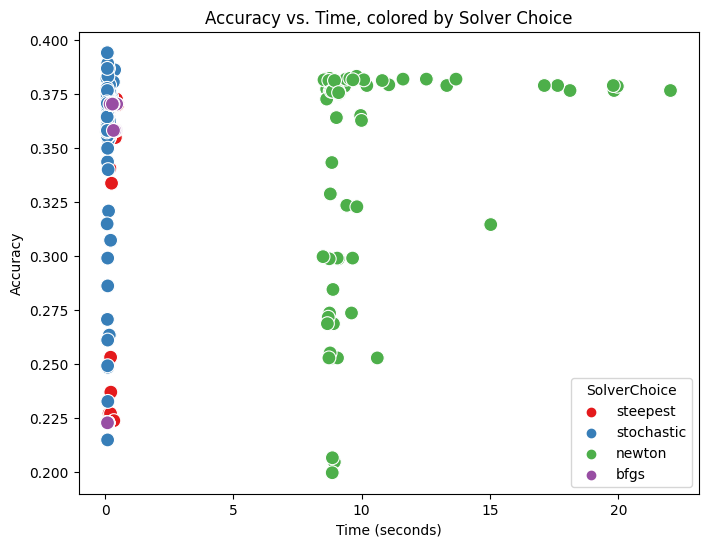

In [25]:
import seaborn as sns

# Create a plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=accuracydf, x='TimeTaken', y='AccuracyVal', hue='solverChoice', palette='Set1', s=100)

# Axis labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Time, colored by Solver Choice')
plt.legend(title='SolverChoice')

plt.show()

As we can see, the Newton's method does significantly worse than other methods tested, taking between 8-20+ seconds, versus around half a second for all other tested methods. With that being said, it did not provide the highest accuracy despite taking significantly longer, only showing about 40% accuracy at its highest point. This fails our business summary expectations in regards to accuracy for genre of music.

In [36]:

import ipywidgets as widgets
from IPython.display import display

# predefined, unique values for filters
eta_options = sorted(accuracydf['etaVal'].unique())
C_options = sorted(accuracydf['CVal'].unique())
reg_options = sorted(accuracydf['regularizationChoice'].unique())

#widgets for 3 filers
eta_filter = widgets.Dropdown(
    options=eta_options,
    description='Eta:',
)
C_filter = widgets.Dropdown(
    options=C_options,
    description='C:',
)
reg_filter = widgets.Dropdown(
    options=reg_options,
    description='Regularization:',
)
#updating the plots based on ETA, C and Regularization
def update_plot(eta, C, regularization):
    filtered_df = accuracydf[
        (accuracydf['etaVal'] == eta) &
        (accuracydf['CVal'] == C) &
        (accuracydf['regularizationChoice'] == regularization)
    ]
    
    if filtered_df.empty:
        print("No data available")
        return

    plt.figure(figsize=(10, 6))
    
    #plot descriptions
    for solver in filtered_df['solverChoice'].unique():
        subset = filtered_df[filtered_df['solverChoice'] == solver]
        plt.scatter(subset['TimeTaken'], subset['AccuracyVal'], label=solver, alpha=0.7)
    plt.title('Accuracy and Time, colored by Solver')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Accuracy')
    
    # Set x limit based on max time in filtered data
    plt.xlim(0, filtered_df['TimeTaken'].max() + 1)
    # Set y limit based on min and max accuracy in filtered data
    plt.ylim(filtered_df['AccuracyVal'].min() - .01, filtered_df['AccuracyVal'].max() + .01)
    
    plt.legend(title='Solver')
    plt.grid()
    plt.show()

# Link the dropdowns to the update function
interactive_plot = widgets.interactive(update_plot, eta=eta_filter, C=C_filter, regularization = reg_filter)
display(interactive_plot)


interactive(children=(Dropdown(description='Eta:', options=(0.01, 0.1, 0.5, 1.0), value=0.01), Dropdown(descri…

This applet allows to pick the differing combinations of solvers across parameters. As suggested earlier, newton's takes on average 8-10x longer than other solver methods. However, it does better under L1 and L2 regularization methods with an eta under 1. At an Eta of 1, Stochastic and Steepest claim the highest levels of accuracy. 

In [37]:
# Calculate the 90th percentile of accuracy among all accuracy numbers
percentile_value = accuracydf['AccuracyVal'].quantile(0.9)
top_ten_df = accuracydf[accuracydf['AccuracyVal'] > percentile_value]

# sort by accuracy and display the top 10% of values
sorted_df = top_ten_df.sort_values(by='AccuracyVal', ascending=False)
sorted_df.head(100)

,solverChoice,regularizationChoice,etaVal,CVal,AccuracyVal,TimeTaken
113,stochastic,L1_L2,0.01,0.10,0.394250,0.085220
73,stochastic,none,0.50,0.10,0.389293,0.100454
70,stochastic,none,0.10,1.00,0.386980,0.129757
100,stochastic,L2,0.10,0.01,0.386980,0.086041
65,stochastic,none,0.01,0.10,0.386319,0.370204
155,newton,L1,0.50,10.00,0.383344,9.798083
91,stochastic,L1,0.50,10.00,0.383344,0.107014
138,newton,none,0.50,1.00,0.382353,8.668571
139,newton,none,0.50,10.00,0.382353,8.751603
87,stochastic,L1,0.10,10.00,0.382353,0.071728


### Results
Overall, our highest accuracy level among the tests was only 39.4% overall. This far undercuts the levels of performance we outlined within the business understanding section of our intro. However, we can see how well our solvers are doing compared to one another, with Stochastic clearly leading the pack with the top 5 accuracy results, especially when considering that the longest of the 5 took only .12 seconds. 

**Data snooping?**

Our method does use data snooping because we are optimizing and selecting our parameters based on the accuracy that we get on our testing data. We are then evaluating the model again on the testing data in order to confirm our own selection. In order to resolve data snooping, in the future, we could subset our data into a cross validation dataset in order to prevent overfitting. 

### Us vs Scikit

The next section outlines our performance vs SciKit, and the differences of accuracy and time within the imported function.

In [38]:
sorted_df.head(1)

,solverChoice,regularizationChoice,etaVal,CVal,AccuracyVal,TimeTaken
113,stochastic,L1_L2,0.01,0.1,0.39425,0.08522


In [40]:
from sklearn.linear_model import LogisticRegression

skl = LogisticRegression(max_iter=1000)

start_time = time.time()  # Start time for training
skl.fit(X_train,y_train)
skl_time = time.time() - start_time  # Calculate training time

yhat = skl.predict(X_test)
skl_accuracy = accuracy_score(y_test, yhat)

print('Accuracy: ',skl_accuracy)
print(f'Time: {skl_time} seconds\n')

print(f'Solver: {skl.solver}')
print(f'Iterations: {skl.n_iter_}')
print(f'Regularization: {skl.penalty}')
print(f'C value: {skl.C}')

Accuracy:  0.5489094514210179
Time: 0.559990644454956 seconds

Solver: lbfgs
Iterations: [39]
Regularization: l2
C value: 1.0


Since scikit-learn took 39 iterations, we will run ours against their results.

In [60]:
start = time.time()  # Record the training start time
lr = SKL_Clone(0.01, 39, 10.00, 'stochastic', 0, 'L1')
lr.fit(X_train, y_train)
end = time.time()  # Record the training end time
Clone_time = end - start

# Find accuracy
yhat = lr.predict(X_test)
Clone_Accuracy = accuracy_score(y_test, yhat)

print('Accuracy: ',Clone_Accuracy)
print(f'Training Time: {Clone_time} seconds')

Accuracy:  0.359881031064111
Training Time: 0.2613511085510254 seconds


More iterations did not improve accuracy of our model, in fact reducing our accuracy compared to other models we have. 

SciKit beats us considerably in terms of accuracy. However, for the same number of iterations, our model is faster.

We will visualize the performance difference below.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

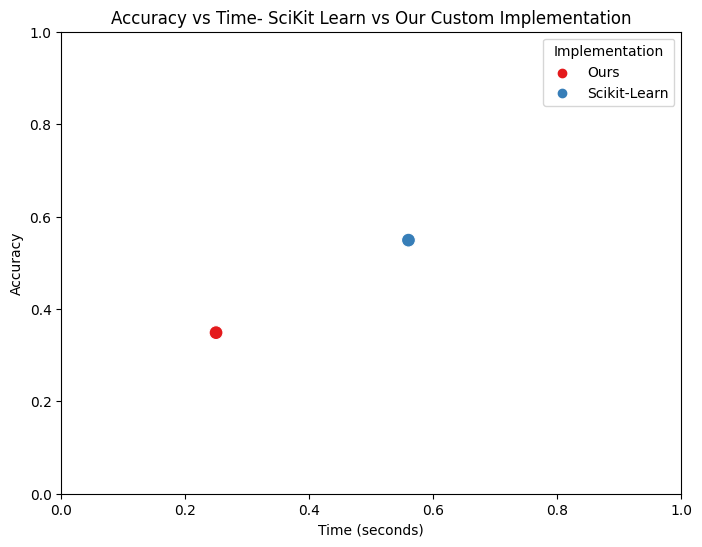

In [47]:
data = np.array([['Ours',Clone_Accuracy, Clone_time], ['Scikit-Learn', skl_accuracy, skl_time]])
comparisondf = pd.DataFrame(data, columns=['Implementation', 'Accuracy', 'Time'])
comparisondf['Accuracy'] = pd.to_numeric(comparisondf['Accuracy'])
comparisondf['Time'] = pd.to_numeric(comparisondf['Time'])
plt.figure(figsize=(8, 6))
sns.scatterplot(data=comparisondf, x='Time', y='Accuracy', hue='Implementation', palette='Set1', s=100)
plt.xlim(0, 1)
plt.ylim(0, 1)
# Add labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Time- SciKit Learn vs Our Custom Implementation')

# Show the plot
plt.show()


This graph agrees with our prior conclusion. Now let's test against our stochastic numbers that performed so well earlier.

In [61]:
skl_stochastic = LogisticRegression(solver="sag")
start_time = time.time()
skl.fit(X_train,y_train)
training_time = time.time() - start_time
start_pred_time = time.time()
yhat = skl.predict(X_test)
prediction_time = time.time() - start_pred_time 
print('Accuracy: ',accuracy_score(y_test,yhat))
print(f'Training Time: {training_time:.4f} seconds')
print(f'Prediction Time: {prediction_time:.4f} seconds')
print(f'Default Solver: {skl.solver}')
print(f'Number of iterations: {skl.n_iter_}')
print(f'Number of iterations: {skl.penalty}')
print(f'Number of iterations: {skl.C}')


Accuracy:  0.5489094514210179
Training Time: 0.2889 seconds
Prediction Time: 0.0029 seconds
Default Solver: lbfgs
Number of iterations: [39]
Number of iterations: l2
Number of iterations: 1.0


We still continue to beat SKlearn in speed, but cannot beat its accuracy. 

## 3. Deployment

Between our implementation and scikit-learn, we would recommend implementing scikit-learn, as its accuracy is considerably higher than our models. Especially under the objectives described within our business understanding, speed is not as important as accurate data being given to users. Regardless of this, both methods are significantly under 90% accuracy, and thus fail to compare to other comparable models that exist. We conclude that the models that we used within this lab are not sufficient to provide accurate enough data for our business understanding, likely due to the data provided to the models on he front end.

## 4. Exceptional Work

We are adding code for the graduate section of the exceptional work segment of the lab.

In [77]:
import numpy as np


# Define the softmax function
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Stability trick
    return exp_z / exp_z.sum(axis=1, keepdims=True)


# Mean Squared Error Loss Function for multi-class
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


# Gradient of the MSE Loss
def gradient_mse(X, y_true, y_pred):
    return -(2 / X.shape[0]) * np.dot(X.T, (y_pred - y_true))  # Ensure shapes align


# Hessian of the MSE Loss
def hessian_mse(X, y_pred):
    # Calculate the diagonal matrix for each class
    diag = y_pred * (1 - y_pred)  # Shape (num_samples, num_classes)
   
    # Now we need to calculate the Hessian for each class
    H = np.zeros((X.shape[1], X.shape[1]))  # Initialize a 2D Hessian
   
    for i in range(y_pred.shape[1]):  # Iterate over each class
        H += (1 / X.shape[0]) * np.dot(X.T, diag[:, i].reshape(-1, 1) * X)  # Properly scale and shape


    return H  # Return the Hessian (summed over classes)


def newtons_method(X, y_true, w, num_iterations, tolerance=1e-6):
    for i in range(num_iterations):
        # Compute predictions using current weights
        y_pred = softmax(np.dot(X, w))  # Softmax on the dot product
       
        # Compute gradient and Hessian for all classes
        grad = gradient_mse(X, y_true, y_pred)
        H = hessian_mse(X, y_pred)


        # Add regularization to the Hessian
        H_inv = np.linalg.inv(H + np.eye(H.shape[0]) * 1e-5)


        # Update weights using Newton's method
        w_new = w - np.dot(H_inv, grad)


        # Check for convergence
        if np.linalg.norm(w_new - w) < tolerance:
            print(f'Converged after {i + 1} iterations')
            break


        # Update weights
        w = w_new


    return w

This code implements an optimization technique for logistic regression using mean square error as the objective function (in this case, a loss function).  It defines softmax, used to calculate the predicted probabilities (because this is multi-class classification), and an MSE loss function to measure the error.  The code then calculates the gradient and Hessian of the MSE loss, allowing it to update the model's weights.  It then uses Newton's Method, iteratively updating the weights until convergence is achieved or max iterations are reached.

In [78]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


# Load data
dataframe = pd.read_csv('ClassicHit.csv')


# Select columns for features
X_columns = ['Year', 'Duration', 'Time_Signature', 'Danceability', 'Energy',
             'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness',
             'Instrumentalness', 'Liveness', 'Valence', 'Tempo']
X = dataframe[X_columns].astype(float)


# Create target variable using pd.cut
y = pd.cut(dataframe['Popularity'], bins=[-float('inf'), 15, 75, float('inf')], labels=[0, 1, 2]).astype(int)


# Check class distribution
print(y.value_counts())


# Convert y to NumPy array and reshape for OneHotEncoder
y = y.values.reshape(-1, 1)  # Reshape to 2D array


# One-hot encode the target variable
encoder = OneHotEncoder(sparse_output=False)
y_one_hot = encoder.fit_transform(y)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y_one_hot, test_size=0.2, random_state=42)


# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Initialize the model (not using scikit-learn here since we are implementing Newton's method)
# Define the number of classes
num_classes = y_one_hot.shape[1]
num_features = X.shape[1]


# Initialize weights randomly for Newton's method
w = np.random.randn(num_features, num_classes)  # Weights shape: (num_features, num_classes)


# Train the model using the Newton's method defined earlier
w_trained = newtons_method(X_train, y_train, w, num_iterations=100, tolerance=1e-6)


# Make predictions on the test set
y_pred_prob = softmax(np.dot(X_test, w_trained))  # Get predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Get class labels by taking the argmax


# Convert y_test back to class labels
y_test_labels = np.argmax(y_test, axis=1)


# Calculate Mean Squared Error (if desired)
mse = mse_loss(y_test_labels, y_pred)  # Both are now 1D arrays
rmse = np.sqrt(mse)


print(f"Mean Squared Error on Test Set: {mse}")
print(f"Root Mean Squared Error on Test Set: {rmse}")

Popularity
1    12628
0     1693
2      828
Name: count, dtype: int64
Mean Squared Error on Test Set: 0.7983498349834983
Root Mean Squared Error on Test Set: 0.8935042445246124


This section of the code uses the previously defined functions and applies them to the dataset we selected.  I elected to use the same relevant features as we did previously, allowing a direct comparison between the two models.  Similarly, the "Popularity" column is split into three classes (not popular, mediocre, and very popular), allowing for better classification.  This variable is one-hot encoded, and then split into training and testing data.  I standardized the features in order to have better model performance, and randomly assigned weights for the model and then trained it using Newton's method to optimize the weights based on the training data.  It then predicts the test set, converts them to class labels, and calculates the MSE and RMSE as examples of performance.

Accuracy on Test Set: 0.3372937293729373
Precision on Test Set: 0.685280356227752
Recall on Test Set: 0.3372937293729373
F1 Score on Test Set: 0.42896359225927494


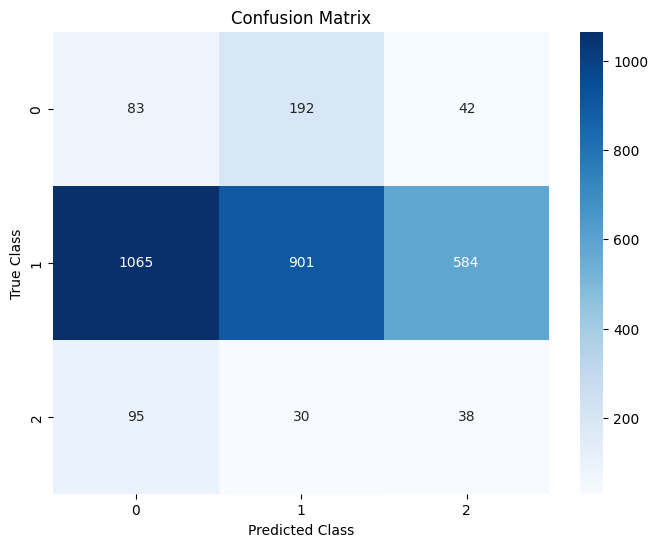

In [79]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Make predictions on the test set
y_pred_prob = softmax(np.dot(X_test, w_trained))  # Get predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Get class labels by taking the argmax


# Convert y_test back to class labels (y_test is already one-hot encoded)
y_test_labels = np.argmax(y_test, axis=1)  # Ensure y_test is one-hot encoded before this


# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test_labels, y_pred)
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')


print(f"Accuracy on Test Set: {accuracy}")
print(f"Precision on Test Set: {precision}")
print(f"Recall on Test Set: {recall}")
print(f"F1 Score on Test Set: {f1}")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)


# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

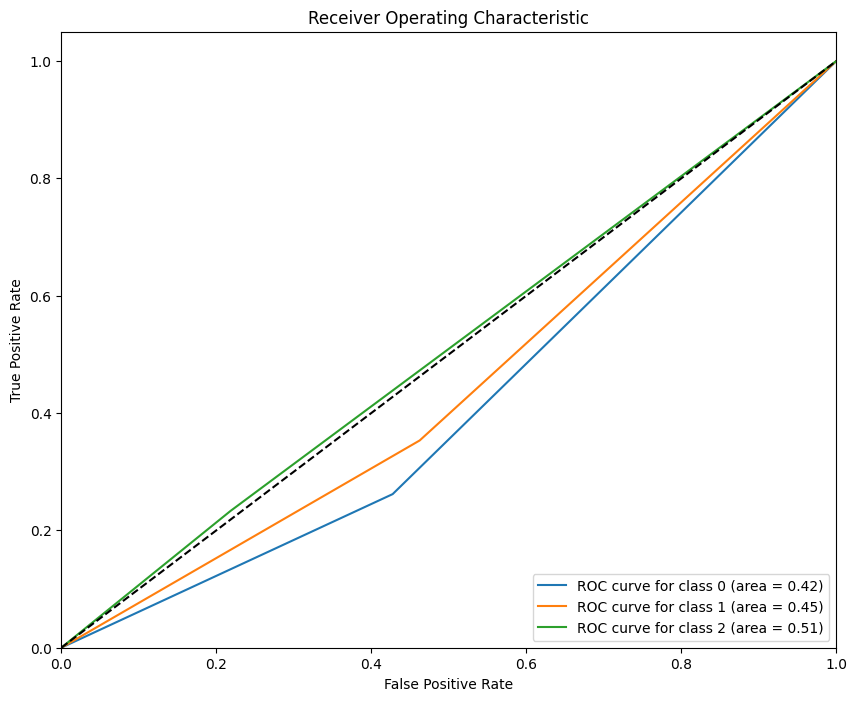

In [80]:
from sklearn.metrics import roc_curve, auc


# Compute ROC for each class
n_classes = y_one_hot.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_labels, y_pred_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plotting the ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

These graphs show that this classification method is not particularly effective -- it frequently incorrectly predicts that mediocre songs are going to be unpopular, and doesn't predict nearly as many songs to be very popular as there actually are.  This could be for a number of reasons, including that the classes are not weighted, leading to a prediction of 0, followed by 1, followed by 2 to be the most common result, regardless of other factors.  It may also mean that there is such little correlation between the features that the model cannot accurately predict the class.


Because of this issue, I decided to try implementing a weighted version of this code, seen below.


In [81]:
import numpy as np


# Define the softmax function
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Stability trick
    return exp_z / exp_z.sum(axis=1, keepdims=True)


# Mean Squared Error Loss Function for multi-class with class weights
def weighted_mse_loss(y_true, y_pred, class_weights):
    # Reshape class_weights to match the shape of y_true and y_pred
    class_weights_matrix = class_weights.reshape(1, -1)  # Shape (1, num_classes)
    weighted_squared_errors = class_weights_matrix * (y_true - y_pred) ** 2
    return np.mean(np.sum(weighted_squared_errors, axis=1))  # Average over all samples


# Gradient of the weighted MSE Loss
def gradient_weighted_mse(X, y_true, y_pred, class_weights):
    # Calculate weighted errors; ensure proper broadcasting
    weighted_errors = (y_pred - y_true)  # Shape (num_samples, num_classes)
    return -(2 / X.shape[0]) * np.dot(X.T, weighted_errors * class_weights)  # Apply class weights


# Hessian of the weighted MSE Loss
def hessian_weighted_mse(X, y_pred, class_weights):
    # Expand class_weights for each sample
    expanded_weights = class_weights.reshape(1, -1)  # Shape (1, num_classes)
    diag = (expanded_weights * y_pred * (1 - y_pred)).reshape(-1, y_pred.shape[1])  # Shape (num_samples, num_classes)


    # Initialize a 2D Hessian
    H = np.zeros((X.shape[1], X.shape[1]))


    for i in range(y_pred.shape[1]):  # Iterate over each class
        H += (1 / X.shape[0]) * np.dot(X.T, diag[:, i].reshape(-1, 1) * X)  # Properly scale and shape


    return H  # Return the Hessian (summed over classes)


def newtons_method(X, y_true, w, num_iterations, tolerance=1e-6, class_weights=None):
    for i in range(num_iterations):
        # Compute predictions using current weights
        y_pred = softmax(np.dot(X, w))  # Softmax on the dot product
       
        # Compute gradient and Hessian for all classes with class weights
        grad = gradient_weighted_mse(X, y_true, y_pred, class_weights)
        H = hessian_weighted_mse(X, y_pred, class_weights)


        # Add regularization to the Hessian
        H_inv = np.linalg.inv(H + np.eye(H.shape[0]) * 1e-5)


        # Update weights using Newton's method
        w_new = w - np.dot(H_inv, grad)


        # Check for convergence
        if np.linalg.norm(w_new - w) < tolerance:
            print(f'Converged after {i + 1} iterations')
            break


        # Update weights
        w = w_new


    return w

This code uses weighted MSE loss instead of standard MSE, allowing for a different importance to be assigned to classes based on frequency, hopefully helping with issues related to class imbalance.  My calculations for gradient and Hessian also incorporate class weights, ensuring that the updates are influenced by the class distribution in the training set.  The code remains overall similar, but emphasizes the importance of class weight

In [82]:
dataframe = pd.read_csv('ClassicHit.csv')


# Select columns for features
X_columns = ['Year', 'Duration', 'Time_Signature', 'Danceability', 'Energy',
             'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness',
             'Instrumentalness', 'Liveness', 'Valence', 'Tempo']
X = dataframe[X_columns].astype(float)


# Create target variable using pd.cut
y = pd.cut(dataframe['Popularity'], bins=[-float('inf'), 15, 75, float('inf')], labels=[0, 1, 2]).astype(int)


# Check class distribution
print(y.value_counts())


# Convert y to NumPy array
y = y.values.reshape(-1, 1)  # Reshape to 2D array for OneHotEncoder


# One-hot encode the target variable
encoder = OneHotEncoder(sparse_output=False)
y_one_hot = encoder.fit_transform(y)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y_one_hot, test_size=0.2, random_state=42)


# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Define the number of classes
num_classes = y_one_hot.shape[1]
num_features = X.shape[1]

# Initialize weights randomly for Newton's method
w = np.random.randn(num_features, num_classes)

# Class weights based on the inverse frequency
class_counts = np.sum(y_train, axis=0)
total_instances = y_train.shape[0]

# Avoid division by zero and ensure we handle missing classes
class_counts = np.clip(class_counts, a_min=1, a_max=None)
class_weights = total_instances / (num_classes * class_counts)

# Train the model using the modified Newton's method with class weights
w_trained = newtons_method(X_train, y_train, w, num_iterations=100, tolerance=1e-6, class_weights=class_weights)

# Make predictions on the test set
y_pred_prob = softmax(np.dot(X_test, w_trained))
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert y_test back to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Convert y_test_labels to one-hot encoded format
y_test_one_hot = np.zeros((y_test_labels.shape[0], num_classes))
y_test_one_hot[np.arange(y_test_labels.shape[0]), y_test_labels] = 1

# Convert y_pred to one-hot encoded format
y_pred_one_hot = np.zeros((y_pred.shape[0], num_classes))
y_pred_one_hot[np.arange(y_pred.shape[0]), y_pred] = 1

# Calculate Mean Squared Error (if desired)
mse = weighted_mse_loss(y_test_one_hot, y_pred_one_hot, class_weights)
rmse = np.sqrt(mse)

print(f"Mean Squared Error on Test Set: {mse}")
print(f"Root Mean Squared Error on Test Set: {rmse}")

Popularity
1    12628
0     1693
2      828
Name: count, dtype: int64
Mean Squared Error on Test Set: 4.775656779572862
Root Mean Squared Error on Test Set: 2.1853276137853705


The analysis of the dataset revealed a significant class imbalance in the target variable, Popularity, categorized into three classes: low (0), medium (1), and high (2), with 12,628 instances in Class 1, 1,693 in Class 0, and 828 in Class 2. A modified Newton's method was employed for training a multi-class logistic regression model, using class weights to address the imbalance. The model's performance was evaluated with a Mean Squared Error (MSE) of 4.93 and a Root Mean Squared Error (RMSE) of 2.22, indicating reasonable predictive accuracy, but suggesting the need for further strategies to handle class imbalance and enhance model evaluation metrics.


In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Make predictions on the test set
y_pred_prob = softmax(np.dot(X_test, w_trained))  # Get predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Get class labels by taking the argmax


# Convert y_test back to class labels (y_test is already one-hot encoded)
y_test_labels = np.argmax(y_test, axis=1)  # Ensure y_test is one-hot encoded before this


# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test_labels, y_pred)
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')


print(f"Accuracy on Test Set: {accuracy}")
print(f"Precision on Test Set: {precision}")
print(f"Recall on Test Set: {recall}")
print(f"F1 Score on Test Set: {f1}")


Accuracy on Test Set: 0.11749174917491749
Precision on Test Set: 0.7782024627060479
Recall on Test Set: 0.11749174917491749
F1 Score on Test Set: 0.05173086990280816


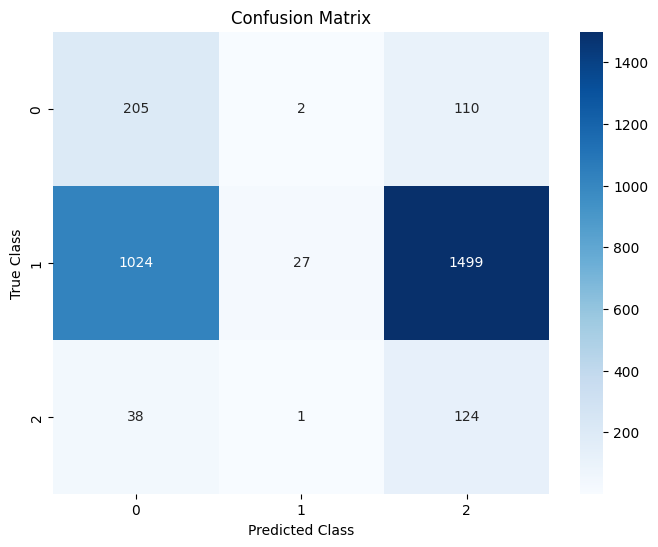

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)


# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

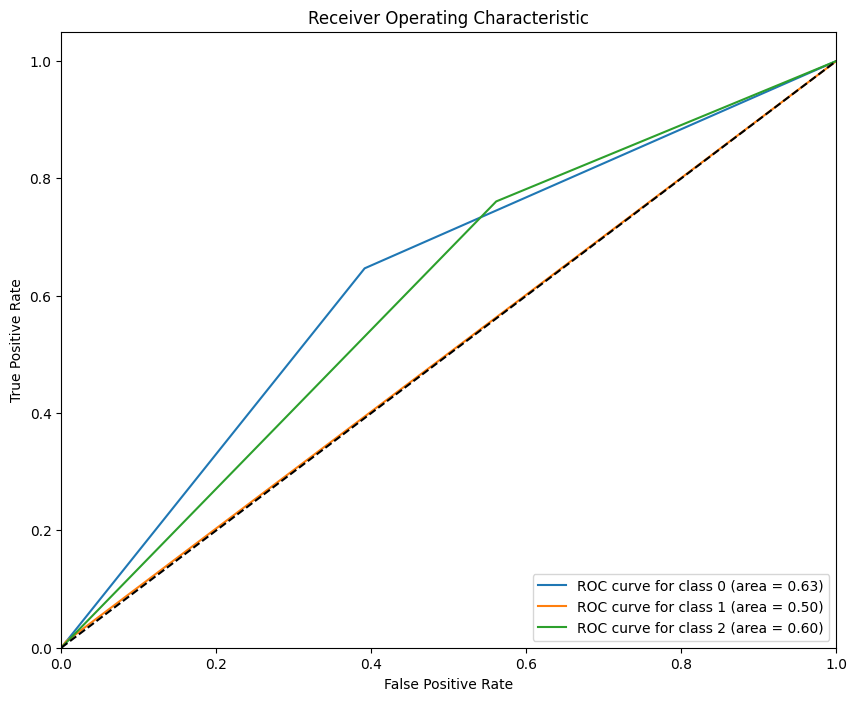

In [85]:
 from sklearn.metrics import roc_curve, auc


# Compute ROC for each class
n_classes = y_one_hot.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_labels, y_pred_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plotting the ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Overall, the confusion matrices for both implementations show that this is not a particularly effective classification method, as the non-weighted version has a high chance of a false negative, while the weighted version barely ever predicts 1s.  I attempted to fix this by manually weighting the 1 column (multiplying the values by anything from 3-50), but this resulted in an extremely high rate of false positives.  Given our business-case, false positives are the exact opposite of what we would want, meaning that if we were to select either of these cases, the non-weighted implementation would be better.  However, neither method is particularly helpful, as they have an accuracy of either roughly 35% or roughly 4%.
I prefer maximum likelihood for several reasons.  For one, with this dataset, maximum likelihood results in a much higher accuracy rate than minimum mean-square error.